### Introduction
This final project explores the best locations for Indian restaurants throughout the city of New York. New York is a major metropolitan area with more than 8.4 million people living within city limits. Additionally, I will attempt to answer the questions “Where should I open an Indian Restaurant?” and “Where should I stay If I want great Indian food?”

### Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

### Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Indian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

### Problem Statement
What is / are the best location(s) for Indian cuisine in New York City?  
In what Neighborhood and/or borough should I open an Indian restaurant to have the best chance of being successful?  
Where would I go in New York City to have the best Indian food?

In [28]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
!pip install folium
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Libraries imported!')

Libraries imported!


In [45]:
CLIENT_ID = 'XXXXXXXXX' 
CLIENT_SECRET = 'XXXXXXXX' 
VERSION = 'XXXXXXX' 

In [46]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    try:
        results = requests.get(url).json()
        venue_data=results["response"]['groups'][0]['items']
    except:
        print(results)
    try:
        venue_details=[]
        for row in venue_data:
            try:
                venue_id=row['venue']['id']
                venue_name=row['venue']['name']
                venue_category=row['venue']['categories'][0]['name']
                venue_details.append([venue_id,venue_name,venue_category])
            except KeyError:
                pass
    except:
        print("Some Exception")
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    try:
        results = requests.get(url).json()
        venue_data=results['response']['venue']
        venue_details=[]
    except:
        print(results)
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    # function to fetch New York dataset
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [47]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs.

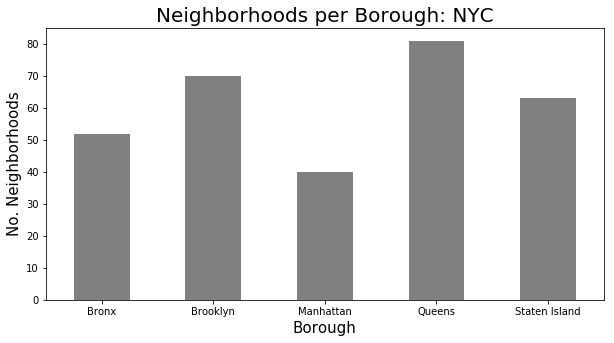

In [48]:
clr = "grey"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

### Lets analyze further and see how many indian restaurants are there in each neighborhood and burough and graph the results.

In [49]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
indian_rest_ny.head()

{'meta': {'code': 500, 'errorType': 'server_error', 'errorDetail': 'Foursquare servers are experiencing problems. Please retry and check status.foursquare.com for updates.'}, 'response': {}}
Some Exception


,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights


In [50]:
# Save the information so far to a .csv file due to limited calls on FourSquare
indian_rest_ny.to_csv('indianRestaurants.csv')

In [52]:
indian_rest_ny = pd.read_csv('indianRestaurants.csv')
indian_rest_ny.head(10)

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill
3,3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal
4,4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights
5,5,Brooklyn,Gowanus,52f18573498ec2c34e830ffd,Kanan's Indian Restaurant
6,6,Brooklyn,Fort Greene,57596dad498e732300496b23,Dosa Royale
7,7,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill
8,8,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's
9,9,Brooklyn,Boerum Hill,543870ec498ec64de510608d,Masala Grill


### As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number if Indian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Greenwich Village has the highest number of Indian restaurants in all of NYC.

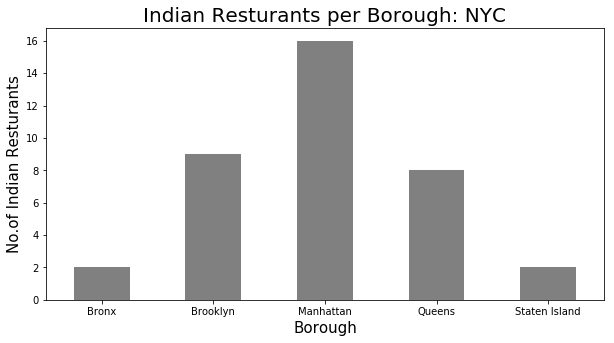

In [53]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Indian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

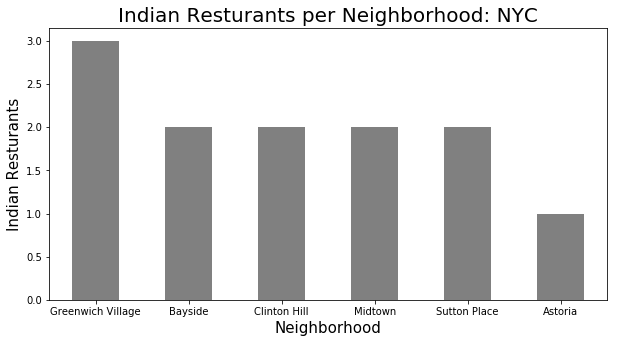

In [54]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [55]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Greenwich Village']

,Unnamed: 0,Borough,Neighborhood,ID,Name
19,19,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda
20,20,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company
21,21,Manhattan,Greenwich Village,4d992c1e942ba093ebb5968c,THELEwala


In [56]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

In [57]:
for row in indian_rest_ny.values.tolist():
    id1,Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.head(10)

No data available for id= 502063b4e4b0c49dd7e1f9b5
No data available for id= 57a27a37498e68b1928c8c66


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.1,10
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,14,7.1,4
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,34,7.3,16
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights,12,5.6,5
5,Brooklyn,Gowanus,52f18573498ec2c34e830ffd,Kanan's Indian Restaurant,24,7.8,8
6,Brooklyn,Fort Greene,57596dad498e732300496b23,Dosa Royale,77,8.8,22
7,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill,20,8.0,6
8,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's,9,5.6,20
9,Brooklyn,Boerum Hill,543870ec498ec64de510608d,Masala Grill,39,8.0,14


In [58]:
indian_rest_stats_ny.to_csv('indian_rest_stats.csv')

In [59]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
Borough         37 non-null object
Neighborhood    37 non-null object
ID              37 non-null object
Name            37 non-null object
Likes           37 non-null float64
Rating          37 non-null float64
Tips            37 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.1+ KB


In [60]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,37.000000,37.000000,37.000000
mean,96.594595,7.391892,32.864865
std,176.701484,1.987793,53.084399
min,0.000000,0.000000,0.000000
25%,12.000000,7.400000,6.000000
50%,29.000000,8.000000,14.000000
75%,81.000000,8.300000,25.000000
max,834.000000,8.900000,258.000000


In [61]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.3
Tips                                 258
Name: 18, dtype: object

In [62]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.9
Tips                                 148
Name: 22, dtype: object

In [63]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.3
Tips                                 258
Name: 18, dtype: object

In [64]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
24,Tribeca,8.900000
7,Fort Greene,8.800000
20,Prospect Lefferts Gardens,8.600000
28,West Village,8.600000
10,Greenwich Village,8.566667
19,Noho,8.500000
23,Sutton Place,8.400000
17,Midtown,8.350000
0,Astoria,8.300000
29,Woodlawn,8.100000


In [65]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.237500
1,Brooklyn,7.422222
0,Bronx,7.000000
3,Queens,6.600000
4,Staten Island,4.050000


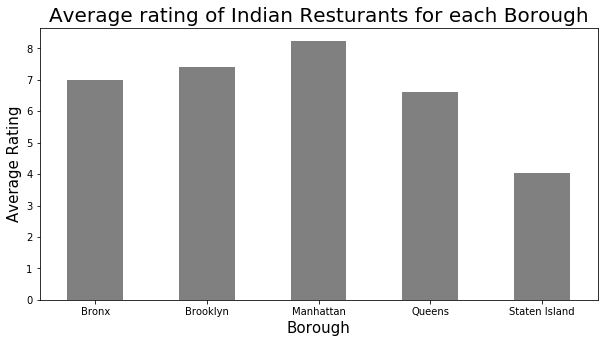

In [66]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

### We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [67]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.300000
3,Boerum Hill,8.000000
7,Fort Greene,8.800000
10,Greenwich Village,8.566667
13,Kew Gardens,8.000000
17,Midtown,8.350000
18,New Dorp,8.100000
19,Noho,8.500000
20,Prospect Lefferts Gardens,8.600000
23,Sutton Place,8.400000


In [68]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.300000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.000000
2,Brooklyn,Fort Greene,40.688527,-73.972906,8.800000
3,Manhattan,Greenwich Village,40.726933,-73.999914,8.566667
4,Queens,Kew Gardens,40.705179,-73.829819,8.000000
5,Manhattan,Midtown,40.754691,-73.981669,8.350000
6,Staten Island,New Dorp,40.572572,-74.116479,8.100000
7,Manhattan,Noho,40.723259,-73.988434,8.500000
8,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.600000
9,Manhattan,Sutton Place,40.760280,-73.963556,8.400000


In [69]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [70]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Finally, we will visualize all NYC buroughs based on average Rating.

#### Results / Conclusion
Manhattan and Brooklyn have the best rated Indian restaurants on average.  
Staten Island and The Bronx have the least amount of Indian restaurants per borough.  
However, Greenwich Village of The Manhattan is the neighborhood in all of NYC with the most Indian Restaurants. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Indian restaurants. Based on this information, I would state that Manhattan and Brooklyn are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open an Indian restaurants in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 7.0 of a scale of 1.0 to 10.0 and has the least number of Indian restaurants making competition easier than in other boroughs.  
Finally, I would go to Tamarind TriBeCa in Manhattan for the best Indian food based on 590 likes with 8.9 rating or The Kati Roll Company in Manhattan with 834 likes.